In [2]:
# Load Modules
import numpy as np
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
import ipywidgets as widgets
from sklearn.metrics.pairwise import kernel_metrics

In [10]:
# Load data
agg_df = pd.read_csv('../data/Final_aggregated(NO_HAWAII).csv')
geo_df = pd.read_csv('../data/lot_lan.csv')
weights_df = pd.read_csv('../data/industry_risks.csv')
industry_df = pd.read_csv('../data/us_state_digit_2019.csv')

In [11]:
# Copy data
df = agg_df.copy()
lat_lon = geo_df.copy()
weights = weights_df.copy()
industry = industry_df.copy()

In [13]:
# for df just keep all columns until rri_score
df = df.loc[:, :'rri_score'] 
# for industry drop unnessary columns
industry = industry.loc[:,~industry.columns.isin(['Unnamed: 0','StateCode','EmpTOT','PayTOT'])] 
# merge data 
df = pd.merge(df, industry,  how='left', left_on=['State'], right_on = ['State'])
# get state abbrevations
us_state_pca = [
    'AL','AK','AZ','AR','CA','CO','CT','DE','DC','FL',
    'GA','ID','IL','IN','IA','KS','KY',
    'LA','ME','MD','MA','MI','MN','MS','MO','MT',
    'NE','NV','NH','NJ','NM','NY','NC','ND',
    'OH','OK','OR','PA','RI','SC','SD','TN','TX','UT'
    ,'VT','VA','WA','WV','WI','WY'
]

In [14]:
# Functions
def weighted_scores(df, weights): #add a list of user input weights to the dataframe created here
  """
  input: final aggregated data, weights defined by industry data
  output: dataframe of average weighted scores by state and industry
  """

  # Get the columns with State name and risk scores
  state_scores = df.loc[:,["State", "bws_score","bwd_score","iav_score","sev_score","gtd_score","rfr_score","cfr_score","drr_score","ucw_score","cep_score","udw_score","usa_score","rri_score"]]
  # Transpose and set index as State
  state_scores_trans = state_scores.set_index('State').T
  # Create a dictionary of Industry to store weights
  weighted_df = {"State":[],"default":[],"agriculture":[],"chemicals":[],
                              "construction materials":[],"electric power":[],
                              "food and beverage":[],"mining":[],"oil and gas":[],
                              "semiconductor":[],"textile":[],
                 }

  # Calculate the weights 
  for idx, state in enumerate(state_scores_trans.columns):
    weighted_df["State"].append(state)
    for industry in ["default","agriculture","chemicals","construction materials","electric power","food and beverage","mining","oil and gas","semiconductor","textile"]:
      here = state_scores.loc[idx,:]
      this = weights.loc[:,industry]

      interm = np.matmul(here[1:].values, this.values)
      w_scores = interm / sum(this.values)

      weighted_df[industry].append(w_scores)

  return weighted_df


def get_data(data, industry_type):
  """
  input: data=merged data, industry_type=picked.value
  output: specific slice of data to cluster by
  """
  if industry_type == 'raw':
    cluster_by_df = data.loc[:,("State", "bws_score","bwd_score","iav_score","sev_score","gtd_score","rfr_score","cfr_score","drr_score","cep_score","udw_score","usa_score")] 
  elif industry_type == 'weighted':  
    cluster_by_df = data.loc[:,("State", "default","agriculture","chemicals","construction materials","electric power",	"food and beverage","mining","oil and gas","semiconductor","textile")]
  elif industry_type == 'industry':
    cluster_by_df = data.loc[:,('State', 
                                'Employment_agriculture',
                                'Employment_chemicals',
                                'Employment_construction',
                                'Employment_electrical', 
                                'Employment_food', 
                                'Employment_mining', 
                                'Employment_oil_and_gas',
                                'Employment_semiconductor', 
                                'Employment_textile',
                              )]

  return(cluster_by_df)


def cluster_by(data, target, scaler=StandardScaler()):
  """
  input: dataframe to prepare for clustering, target feature to cluster by, scaler (default is StandardScaler)
  output: dataframe with target feature dropped and scaled values
  """

  # Determine what to cluster by and drop that feature from df
  state = data[[target]]
  df_k = data.drop([target], axis=1)

  # Scale values 
  x = df_k.values
  scaled = scaler.fit_transform(x) #data and df_k is not correct

  # Get Column Names (except for State names)
  columns = data.columns.tolist()
  columns.pop(0) 

  return(pd.DataFrame(scaled, columns = columns))


def run_kmeans(data, n_Cluster):
  """
  input: prepared dataframe for clustering
  output: data with cluster labels
  """
  # run k-means clustering
  kmeans = KMeans(n_clusters=n_Cluster, random_state=0).fit(data)
  data['cluster']  = kmeans.labels_
  
  return data, kmeans


def create_map_data(data, clustered_df):
  """
  input: dataframe with all risks, weighted scores, lat, lon info included & dataframe with cluster label
  output: dataframe prepared for mapping
  """
  data['cluster'] = clustered_df['cluster']
  map_df = data.sort_values(by=['cluster'])
  map_df = map_df.reset_index()
  return(map_df)


def find_limits(map_df):
  """
  input: dataframe prepared for mapping
  output: limits (list)
  """
  limits = []
  for cluster in map_df['cluster'].unique():
    idx = map_df.index[map_df['cluster'] == cluster].tolist()
    min = np.min(idx)
    max = np.max(idx)
    limits.append((min, max + 1))
  return(limits)


# PCA
def get_pca(data, scaler=StandardScaler()):
  scaler.fit(data)
  X=scaler.transform(data)
  pca = PCA()
  x_new = pca.fit_transform(X)  
  return pca, x_new


# Biplot (2D)
def plot2d(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    # this line changes size of plot, can change it if too big
    plt.figure(figsize=(12,12))
    plt.scatter(xs * scalex,ys * scaley, c = ys)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    # the two following lines adds state abbreviations onto plot
    for i in range(50):
      plt.annotate(us_state_pca[i], (xs[i]*scalex, ys[i]*scaley + 0.02))
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.show()


# Biplot (3D)
def plot3d(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    zs = score[:,2]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    scalez = 1.0/(zs.max() - zs.min())
    # this line changes size of plot, can change it if too big
    #plt.figure(figsize=(12,12))
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    scatter =  ax.scatter(xs * scalex,ys * scaley, zs * scalez, c = ys)
    for i in range(n):
      ax.quiver(0, 0, 0, coeff[i,0], coeff[i,1], coeff[i,2], length = 1, color = 'r')
      ax.text(coeff[i,0], coeff[i,1], coeff[i,2], labels[i], color = 'g')     
    # the two following lines adds state abbreviations onto plot
    for i in range(50):
      ax.text(xs[i]*scalex,ys[i]*scaley,zs[i]*scalez, us_state_pca[i])     
    ax.set_xlabel("PC{}".format(1))
    ax.set_ylabel("PC{}".format(2))
    ax.set_zlabel("PC{}".format(3))
    plt.show()


def scree_plot(pca):
  PC_values = np.arange(pca.n_components_) + 1
  plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
  plt.title('Scree Plot')
  plt.xlabel('Principal Component')
  plt.ylabel('Variance Explained')
  plt.show()


In [15]:
#Construct weighted dataframe by industry 
weighted_df = pd.DataFrame.from_dict(weighted_scores(df, weights))
#Merge weighted industry dataframe to original data (data w/ all risks & payroll, etc.)
merged = pd.merge(df, weighted_df,  how='left', left_on=['State'], right_on = ['State'])
#Merge geo info to original data as well
merged = pd.merge(merged, lat_lon, how='left', left_on=['State'], right_on = ['State'])

In [16]:
def main(data, test, industry_type, opt_k):

  kmeans_df, kmeans = run_kmeans(test, opt_k)

  # Map
  map_df = create_map_data(data, kmeans_df)
  limits = find_limits(map_df)
  map_df['text'] = map_df['State']  #+ '<br>bws score: ' + map_df['bws_score'].astype(str) #will include 3 top scores if i have time
  scale = 5000

  fig = go.Figure()

  for i in range(len(limits)):
      lim = limits[i]
      df_sub = map_df[lim[0]:lim[1]]
      # Overlay bubbles on map
      fig.add_trace(go.Scattergeo(
          locationmode = 'USA-states',
          lon = df_sub['Longitude'],
          lat = df_sub['Latitude'],
          text = df_sub['text'],
          marker = dict(
              size = df_sub['bws_score'] *100,
              # color = df_sub['cluster'],
              line_color='rgb(40,40,40)',
              line_width=0.5,
              sizemode = 'area'
          ),
          name = 'Cluster: {}'.format(df_sub['cluster'].unique()[0])
          ))

  # Update plot layout
  fig.update_layout(
          title_text = f'2019 US {industry_type} Water Risks<br>(Click legend to toggle traces)',
          showlegend = True,
          geo = dict(
              scope = 'usa',
              landcolor = 'rgb(217, 217, 217)',
          )
      )
  
  fig.show()

# PCA Analysis by

1. raw scores

2. weighted scores

3. industry

# 1. raw scores

In [17]:
cluster_by_raw = get_data(merged, 'raw')
raw_cluster = cluster_by(cluster_by_raw, 'State')
# insert labels
raw_labels = ['bws', 'bwd', 'iav', 'sev', 'gtd', 'rfr', 'cfr', 'drr', 'cep', 'udw', 'usa']

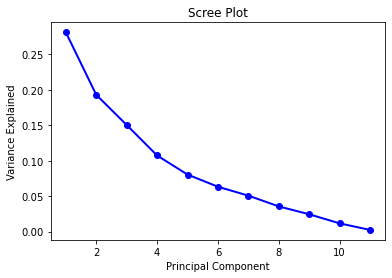

In [18]:
# PCA Scree Plot
pca, x_new = get_pca(raw_cluster)
scree_plot(pca)

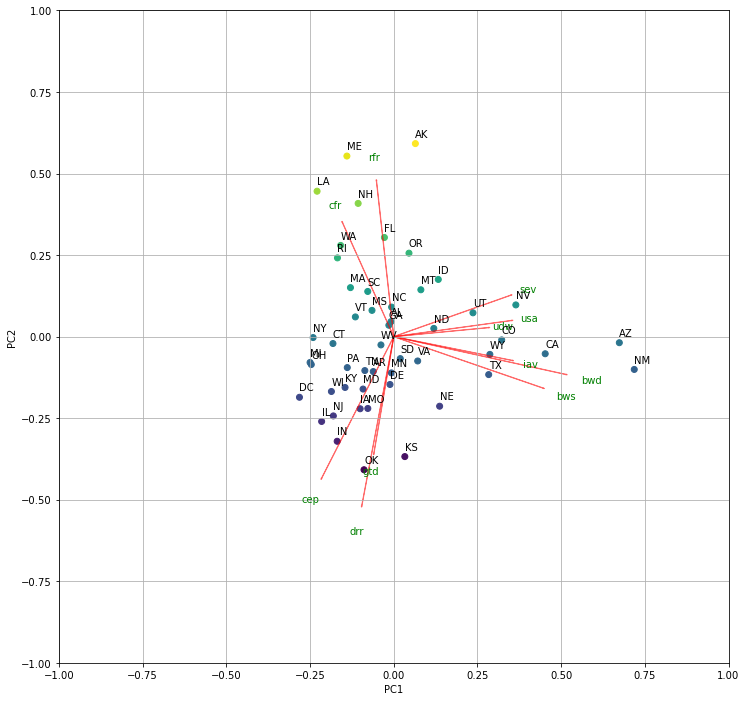

In [19]:
# PCA biplot 2D
plot2d(x_new[:,0:2], np.transpose(pca.components_[0:2, :]), raw_labels)

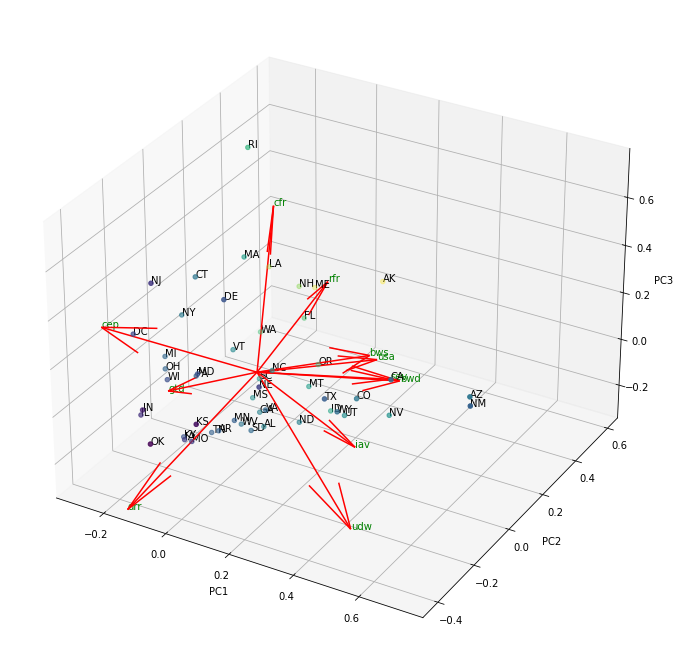

In [20]:
# 3d biplot
plot3d(x_new[:,0:3], np.transpose(pca.components_[0:3, :]), raw_labels)

# 2. weighted scores

In [21]:
cluster_by_weights = get_data(merged, 'weighted')
weighted_cluster = cluster_by(cluster_by_weights, 'State')
weighted_labels = [ 'default','agriculture', 'chemicals', 'construction', 'electrical','food', 'mining',
             'oil_and_gas', 'semiconductor', 'textile']

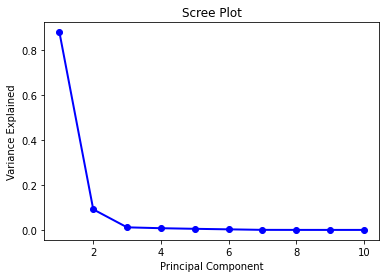

In [22]:
# PCA Scree Plot
pca, x_new = get_pca(weighted_cluster)
scree_plot(pca)

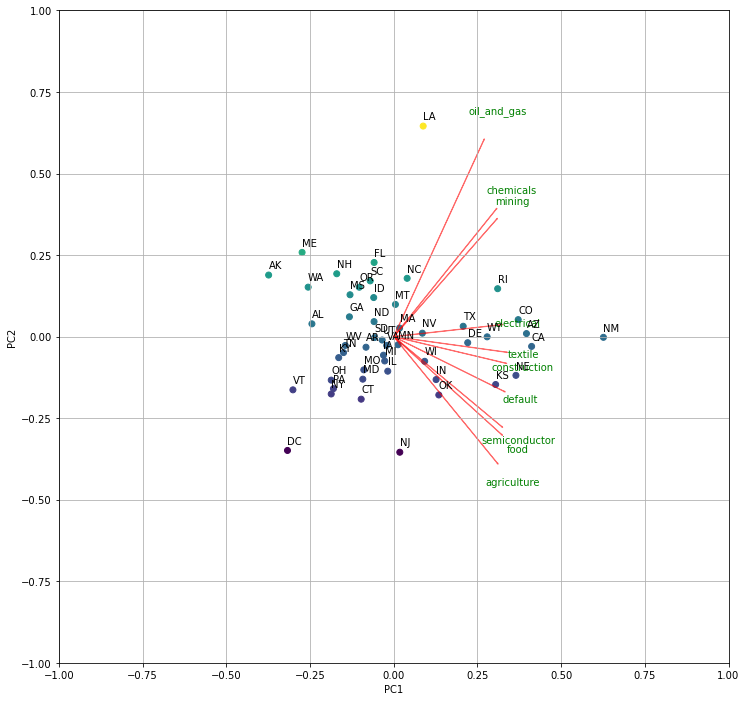

In [23]:
#Call the function. Use only the 2 PCs.
plot2d(x_new[:,0:2], np.transpose(pca.components_[0:2, :]), weighted_labels)

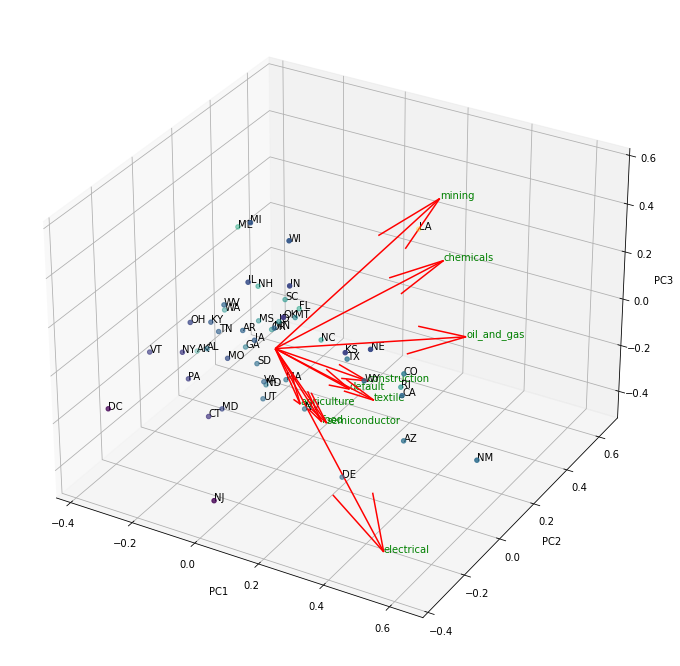

In [24]:
# 3d biplot
plot3d(x_new[:,0:3], np.transpose(pca.components_[0:3, :]), weighted_labels)

# 3. Industry

In [25]:
cluster_by_industry = get_data(merged, 'industry')
industry_cluster = cluster_by(cluster_by_industry, 'State')

# create labels for industry
ind_labels = [ 'agriculture', 'chemicals', 'construction', 'electrical','food', 'mining',
              'oil_and_gas', 'semiconductor', 'textile']

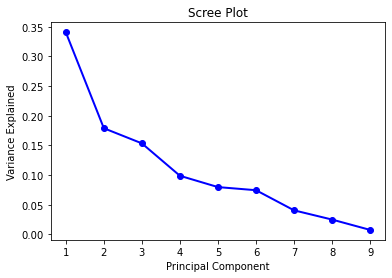

In [26]:
# PCA Scree Plot
pca, x_new = get_pca(industry_cluster)
scree_plot(pca)

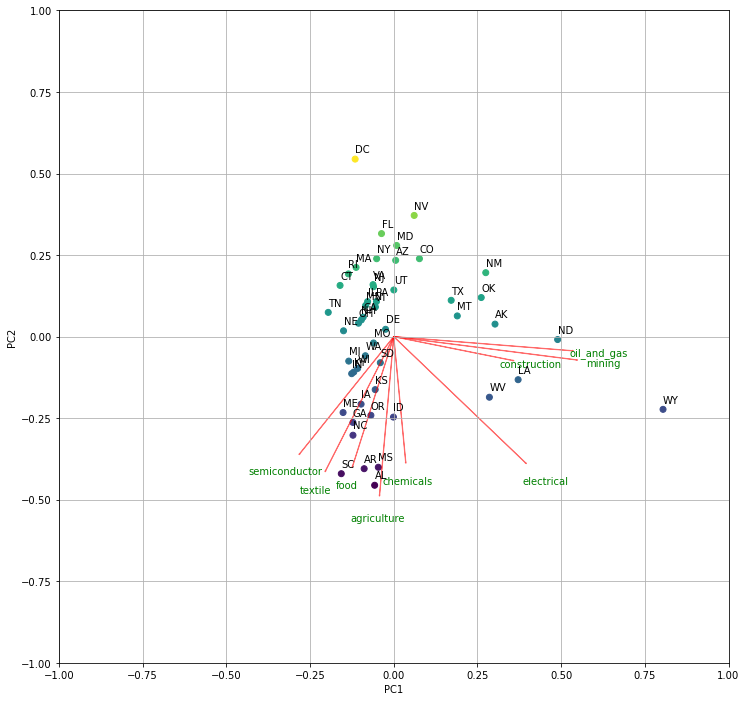

In [27]:
#Call the function. Use only the 2 PCs.
plot2d(x_new[:,0:2], np.transpose(pca.components_[0:2, :]), ind_labels)

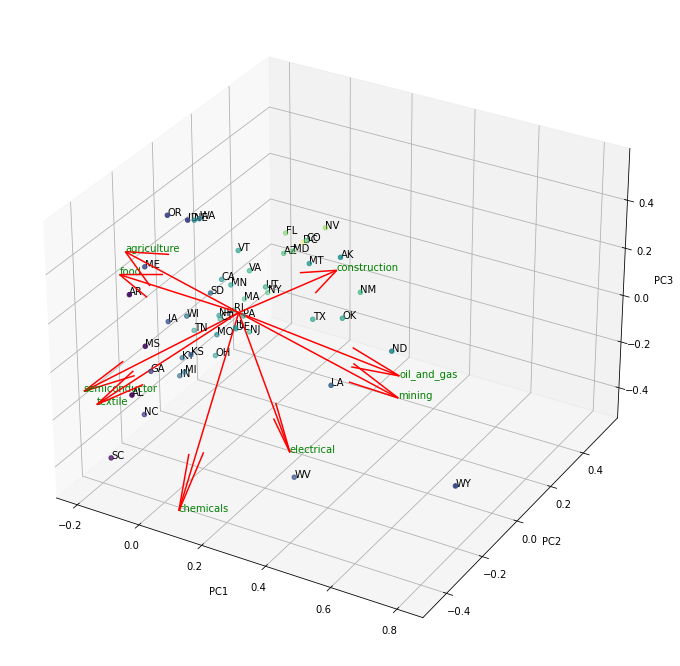

In [28]:
# 3d biplot
plot3d(x_new[:,0:3], np.transpose(pca.components_[0:3, :]), ind_labels)

# Plot by different clusters 

In [41]:
from IPython.display import display

In [48]:
picked = widgets.Dropdown(
  options=[
           ('Cluster by raw scores', 'raw'), # scores = 11 risk scores by state
           ('Cluster by weighted scores', 'weighted'),
           ('Cluster by industry', 'industry'),
          ],
  value='raw',
  description='Cluster by: ',
)
picked

Dropdown(description='Cluster by: ', options=(('Cluster by raw scores', 'raw'), ('Cluster by weighted scores',…

In [49]:
if __name__ == '__main__':
  if picked.value == 'raw':
    main(merged, raw_cluster, picked.value, 3) #3 = number of clusters chosen by interpreting the biplot above
  elif picked.value == 'weighted':
    main(merged, weighted_cluster, picked.value, 2) #2 = number of clusters chosen by interpreting the biplot above
  elif picked.value == 'industry':
    main(merged, industry_cluster, picked.value, 3) #3 = number of clusters chosen by interpreting the biplot above

#3 seems good for the raw scores since on the biplot shows three distinct groups
#2 for the weighted scores
#Industry is 3 due to interpretabililty, 
#there's the group for oil mining and construction;
#a group for chemicals, agriculture, etc; 
#and a group for those that had low loadings on all of the industries

Below are the weighted risk scores by industry

In [31]:
weighted_df

,State,default,agriculture,chemicals,construction materials,electric power,food and beverage,mining,oil and gas,semiconductor,textile
0,Alabama,0.914417,1.093551,0.798494,0.897792,0.880386,1.010106,0.837268,0.684788,0.976558,0.874944
1,Alaska,0.673667,0.794820,0.822684,0.744131,0.795962,0.747521,0.762130,0.671898,0.878198,0.783713
2,Arizona,1.722245,1.809571,1.214570,1.625092,1.667705,1.834134,1.164412,0.946032,1.511830,1.315251
3,Arkansas,1.074680,1.381613,0.903378,1.041847,1.043672,1.215452,0.946264,0.703127,1.162806,0.978644
4,California,1.699736,1.856078,1.279639,1.637426,1.679036,1.843089,1.198785,0.880485,1.564554,1.312211
5,Colorado,1.637040,1.778115,1.263815,1.571713,1.653132,1.746690,1.221663,0.894757,1.503170,1.267319
6,Connecticut,1.059657,1.401262,0.898640,1.049764,1.120545,1.263383,0.839197,0.614090,1.224170,0.976335
7,Delaware,1.401965,1.706640,1.097522,1.352372,1.557691,1.588146,1.046231,0.868944,1.417382,1.193612
8,District of Columbia,0.828041,1.254658,0.702215,0.821261,0.869489,1.060599,0.697196,0.439229,1.070491,0.828396
9,Florida,1.070621,1.177473,1.058824,1.085657,1.144750,1.135636,1.010949,0.782075,1.073629,0.977354
